In [ ]:
import os
import re
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up Google Drive access

In [ ]:
# Mount Google Drive. Confirm access permissions to permit this notebook to access your Google Drive files
from google.colab import drive
drive.mount('/content/drive')
# drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# change proj_gdrive_dir string to personal gdrive project code path

proj_gdrive_dir = '/content/drive/MyDrive/' + 'datasci-210-project/fraud-detect'
data_dir = proj_gdrive_dir + '/data' # Assign data folder under project code path. Create separately in Gdrive
!ls $proj_gdrive_dir
print('-----------------------------------------------------------------------')
!ls $data_dir

data  fraud_detect_eda.ipynb
-----------------------------------------------------------------------
Assistance_PrimeAwardSummaries_2020.csv
Assistance_PrimeAwardSummaries_2021.csv
Assistance_PrimeAwardSummaries_2022_2023.csv


In [ ]:
# Run after completing Notebook run to gracefully disconnect Gdrive
# drive.flush_and_unmount()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Data

In [ ]:
# EIDL data set as temporarily link downloaded from USASpending.gov. Reference group GDrive fraud-detect/data folder

# Setting SBA loan data URLs

sba_ppp_dict_url = 'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/aab8e9f9-36d1-42e1-b3ba-e59c79f1d7f0/download/ppp-data-dictionary.xlsx'
sba_ppp_url_list = [
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/4b3c3e7a-1286-4883-b857-d37058f9693c/download/public_150k_plus_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/c95195f6-0af6-4b84-8c65-e7cd6b940cc2/download/public_up_to_150k_1_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/eaa51a51-ef19-4c22-affe-61ede7253c6f/download/public_up_to_150k_2_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/eaa51a51-ef19-4c22-affe-61ede7253c6f/download/public_up_to_150k_3_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/b4ec101e-ad78-4a25-a058-ab03b049766b/download/public_up_to_150k_4_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/ea284b67-d0b7-4e65-bc48-663e9bb6dac1/download/public_up_to_150k_5_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/ef56afe8-08f8-4bfa-8a58-29690f5baae0/download/public_up_to_150k_6_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/81f1e2be-28a2-4854-bfe1-1e0d408f9fd0/download/public_up_to_150k_7_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/6ada73a2-8176-4e71-8689-30490d9f8a2f/download/public_up_to_150k_8_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/985f0c28-e799-4940-94a9-96a7c5c604a6/download/public_up_to_150k_9_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/3487edaa-92b3-47f4-b147-06fd6d79f786/download/public_up_to_150k_10_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/3487edaa-92b3-47f4-b147-06fd6d79f786/download/public_up_to_150k_11_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/3487edaa-92b3-47f4-b147-06fd6d79f786/download/public_up_to_150k_12_230630.csv',]

# Setting SBA 7(a) & 504 data URLs

sba_7a504_dict_url = 'https://data.sba.gov/dataset/0ff8e8e9-b967-4f4e-987c-6ac78c575087/resource/6898b986-a895-47b4-bb7e-c6b286b23a7b/download/7a_504_foia-data-dictionary.xlsx'
sba_7a504_url_list = [
    'https://data.sba.gov/dataset/0ff8e8e9-b967-4f4e-987c-6ac78c575087/resource/e8023bd1-7d8e-4bd2-8346-47cb6b367beb/download/foia-504-fy2010-present-asof-230630.csv',
    'https://data.sba.gov/dataset/0ff8e8e9-b967-4f4e-987c-6ac78c575087/resource/02e2e83a-2af1-4ce8-91db-85e20ffadbf7/download/foia-7afy2010-fy2019-asof-230630.csv',
    'https://data.sba.gov/dataset/0ff8e8e9-b967-4f4e-987c-6ac78c575087/resource/c71ba6cf-b4e0-4e60-98f0-48aeaf4c6460/download/foia-7afy2020-present-asof-230630.csv']

# Setting NAICS data URLs

naics_2017_2to6_digit_url = 'https://www.census.gov/naics/2017NAICS/2-6%20digit_2017_Codes.xlsx'
naics_2017_6_digit_url = 'https://www.census.gov/naics/2017NAICS/6-digit_2017_Codes.xlsx'
naics_2022_2to6_digit_url = 'https://www.census.gov/naics/2022NAICS/2-6%20digit_2022_Codes.xlsx'
naics_2022_6_digit_url = 'https://www.census.gov/naics/2022NAICS/6-digit_2022_Codes.xlsx'


In [ ]:
# Change working directory to data directory and display contents

%cd $data_dir
!ls

/content/drive/.shortcut-targets-by-id/1J965JUnWOE3IpK9P4gOsAH7kDWatTl0W/datasci-210-project/fraud-detect/data
Assistance_PrimeAwardSummaries_2020.csv
Assistance_PrimeAwardSummaries_2021.csv
Assistance_PrimeAwardSummaries_2022_2023.csv


In [ ]:
# Run first time to download SBA PPP data to Google Drive

# !curl -O $sba_ppp_dict_url
# for url in sba_ppp_url_list:
#   !curl -O {url}

# Run first time to download SBA 7(a) and 504 loan data to Google Drive

# !curl -O {sba_7a504_dict_url}
# for url in sba_7a504_url_list:
#   !curl -O {url}

# Run first time to download NAICS codes to Google Drive

# !curl -O {naics_2017_2to6_digit_url}
# !curl -O {naics_2017_6_digit_url}
# !curl -O {naics_2022_2to6_digit_url}
# !curl -O {naics_2022_6_digit_url}

# !ls

In [ ]:
# Load SBA PPP files into data frame from individual files
ppp_files_li = [filename for filename in os.listdir(data_dir) if filename.startswith('public_')]
df_ppp_data = pd.concat([pd.read_csv(data_dir+'/'+filename, header=0) for filename in ppp_files_li], ignore_index=True)

# filename = 'sba_ppp_combined.csv'

# Only run once if need to combine individual SBA PPP files into one
# df_ppp_data.to_csv(data_dir+'/'+filename, index=False)

# Load SBA PPP files into data frame from combined file
# df_ppp_data = pd.read_csv(data_dir+'/'+filename, header=0, ignore_index=True)

ValueError: ignored

In [ ]:
# Load SBA PPP Data Dictionary into data frame
filename = 'ppp-data-dictionary.xlsx'
df_ppp_dict = pd.read_excel(data_dir+'/'+filename, header=0)

FileNotFoundError: ignored

In [ ]:
eidl_files_li = [
    'Assistance_PrimeAwardSummaries_2020.csv',
    'Assistance_PrimeAwardSummaries_2021.csv',
    'Assistance_PrimeAwardSummaries_2022_2023.csv']

df_eidl_data = pd.concat([pd.read_csv(data_dir+'/'+filename, header=0) for filename in eidl_files_li], ignore_index=True)

<ipython-input-11-41cc5bf97652>:6: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  df_eidl_data = pd.concat([pd.read_csv(data_dir+'/'+filename, header=0) for filename in eidl_files_li], ignore_index=True)
<ipython-input-11-41cc5bf97652>:6: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  df_eidl_data = pd.concat([pd.read_csv(data_dir+'/'+filename, header=0) for filename in eidl_files_li], ignore_index=True)
<ipython-input-11-41cc5bf97652>:6: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  df_eidl_data = pd.concat([pd.read_csv(data_dir+'/'+filename, header=0) for filename in eidl_files_li], ignore_index=True)


In [ ]:
# Loading NAICS File into data frame

# df_naics_2to6_2017 = pd.read_excel(naics_url, header=0, index_col=None, dtype={'2022 NAICS Code':str})

filename = '2-6%20digit_2017_Codes.xlsx'
df_naics_2to6_2017 = pd.read_excel(data_dir+'/'+filename, header=0, index_col=None, dtype={'2017 NAICS Code':str}).dropna(thresh=2).dropna(axis='columns')

filename = '2-6%20digit_2022_Codes.xlsx'
df_naics_2to6_2022 = pd.read_excel(data_dir+'/'+filename, header=0, index_col=None, dtype={'2022 NAICS Code':str}).dropna(thresh=2).dropna(axis='columns')

filename = '6-digit_2017_Codes.xlsx'
df_naics_6_2017 = pd.read_excel(data_dir+'/'+filename, header=0, index_col=None, dtype={'2017 NAICS Code':str}).dropna(thresh=2).dropna(axis='columns')

filename = '6-digit_2022_Codes.xlsx'
df_naics_6_2022 = pd.read_excel(data_dir+'/'+filename, header=0, index_col=None, dtype={'2022 NAICS Code':str}).dropna(thresh=2).dropna(axis='columns')

In [ ]:
# Load SBA 7(a) and 504 loan data dictionary into data frame
filename = '7a_504_foia-data-dictionary.xlsx'
df_7a_504_dict = pd.read_excel(data_dir+'/'+filename, header=0)

In [ ]:
# Load SBA 7(a) and 504 loan data into data frame
# Modified 7(a) csv encoding due to byte error with UTF-8

filename = 'foia-7afy2010-fy2019-asof-230630.csv'
filename2 = 'foia-7afy2020-present-asof-230630.csv'
df_7a_data = pd.concat([pd.read_csv(data_dir+'/'+filename, header=0, encoding='latin1'), pd.read_csv(data_dir+'/'+filename2, header=0, encoding='latin1')], ignore_index=True)

filename = 'foia-504-fy2010-present-asof-230630.csv'
df_504_data = pd.read_csv(data_dir+'/'+filename, header=0)

<ipython-input-74-d348d0180ce5>:6: DtypeWarning: Columns (13,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_7a_data = pd.concat([pd.read_csv(data_dir+'/'+filename, header=0, encoding='latin1'), pd.read_csv(data_dir+'/'+filename2, header=0, encoding='latin1')], ignore_index=True)
<ipython-input-74-d348d0180ce5>:6: DtypeWarning: Columns (34,35,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df_7a_data = pd.concat([pd.read_csv(data_dir+'/'+filename, header=0, encoding='latin1'), pd.read_csv(data_dir+'/'+filename2, header=0, encoding='latin1')], ignore_index=True)
<ipython-input-74-d348d0180ce5>:9: DtypeWarning: Columns (32,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df_504_data = pd.read_csv(data_dir+'/'+filename, header=0)


# Reviewing data sets

In [ ]:
display(df_ppp_dict)
# df_ppp_data.columns.values.tolist()
print('\n\nLoan Number # of NA', df_ppp_data['LoanNumber'].isnull().sum(axis = 0))

,Field Name,Field Description
0,LoanNumber,Loan Number (unique identifier)
1,DateApproved,Loan Funded Date
2,SBAOfficeCode,SBA Origination Office Code
3,ProcessingMethod,Loan Delivery Method (PPP for first draw; PPS ...
4,BorrowerName,Borrower Name
5,BorrowerAddress,Borrower Street Address
6,BorrowerCity,Borrower City
7,BorrowerState,Borrower State
8,BorrowerZip,Borrower Zip Code
9,LoanStatusDate,Loan Status Date\n- Loan Status Date is blank...




Loan Number # of NA 0


In [ ]:
df_ppp_data.describe

<bound method NDFrame.describe of           LoanNumber DateApproved  SBAOfficeCode ProcessingMethod  \
0         2593527208   04/16/2020         1094.0              PPP   
1         2741007306   04/29/2020         1087.0              PPP   
2         3342508906   04/28/2021         1087.0              PPP   
3         3379798208   08/04/2020         1087.0              PPP   
4         3753429003   05/20/2021         1087.0              PPP   
...              ...          ...            ...              ...   
11765547  8355007904   06/18/2020         1087.0              PPP   
11765548  1561987806   05/21/2020         1087.0              PPP   
11765549  1742097308   04/28/2020         1087.0              PPP   
11765550  2188397409   05/05/2020         1087.0              PPP   
11765551  2192137404   05/05/2020         1087.0              PPP   

                               BorrowerName             BorrowerAddress  \
0                      LORI L. HOLDER, LCSW       504 MAIN ST 

In [ ]:
print(df_eidl_data.head(), '\n\n', df_eidl_data.count())

       assistance_award_unique_key      award_id_fain  award_id_uri  \
0  ASST_NON_EIDLGT:3300291346_7300  EIDLGT:3300291346           NaN   
1  ASST_NON_EIDLGT:3300287138_7300  EIDLGT:3300287138           NaN   
2  ASST_NON_EIDLGT:3300170604_7300  EIDLGT:3300170604           NaN   
3  ASST_NON_EIDLGT:3300642497_7300  EIDLGT:3300642497           NaN   
4  ASST_NON_EIDLGT:3300059149_7300  EIDLGT:3300059149           NaN   

   sai_number                      disaster_emergency_fund_codes  \
0  SAI EXEMPT  O: Non-emergency P.L. 116-136|Non-emergency P....   
1  SAI EXEMPT  O: Non-emergency P.L. 116-136|Non-emergency P....   
2  SAI EXEMPT  O: Non-emergency P.L. 116-136|Non-emergency P....   
3  SAI EXEMPT  O: Non-emergency P.L. 116-136|Non-emergency P....   
4  SAI EXEMPT  O: Non-emergency P.L. 116-136|Non-emergency P....   

   outlayed_amount_from_COVID-19_supplementals  \
0                                      10000.0   
1                                      10000.0   
2             

In [ ]:
print(df_naics_6_2022.head(), '\n\n', df_naics_6_2022.count())

  2022 NAICS Code                   2022 NAICS Title
1          111110                    Soybean Farming
2          111120  Oilseed (except Soybean) Farming 
3          111130          Dry Pea and Bean Farming 
4          111140                      Wheat Farming
5          111150                      Corn Farming  

 2022 NAICS Code     1012
2022 NAICS Title    1012
dtype: int64


In [ ]:
display(df_7a_504_dict)

,Field Name,Definition
0,AsOfDate,Date when the data was recorded
1,Program,Indicator of whether loan was approved under S...
2,BorrName,Borrower name
3,BorrStreet,Borrower street address
4,BorrCity,Borrower city
5,BorrState,Borrower state
6,BorrZip,Borrower zip code
7,BankName,Name of the bank that the loan is currently as...
8,BankFDICNumber,The Federal Depository Insurance Corporation c...
9,BankNCUANumber,The National Credit Union Association charter ...


In [ ]:
print(df_7a_data.head(), '\n\n', df_7a_data.count())

   AsOfDate Program                       BorrName              BorrStreet  \
0  20230630      7A             CALIFORNIA COPY LA     1001 S. BROADWAY #G   
1  20230630      7A                   G. Pear Inc.     204 S. Western Ave.   
2  20230630      7A               Colorado Pilates     16329 Avalanche Run   
3  20230630      7A  Advanced Testing Services LLC  1455 New England Dr NE   
4  20230630      7A  Stavis Creek Enviromental LLC        5958 Minnig Lane   

          BorrCity BorrState  BorrZip  \
0      LOS ANGELES        CA    90015   
1  Carpentersville        IL    60110   
2       Broomfield        CO    80023   
3     North Canton        OH    44720   
4          Seabeck        WA    98312   

                                            BankName  BankFDICNumber  \
0                                       Bank of Hope         26610.0   
1               BMO Harris Bank National Association         16571.0   
2          JPMorgan Chase Bank, National Association           628.0

In [ ]:
print(df_504_data.head(), '\n\n', df_504_data.count())

   AsOfDate  Program                        BorrName  \
0  20230630      504                   Turning Brook   
1  20230630      504                     Hammes Seed   
2  20230630      504             Rocket Express, LLC   
3  20230630      504              Martin Harper P.C.   
4  20230630      504  Shield Security Systems, L.L.C   

                       BorrStreet          BorrCity BorrState  BorrZip  \
0    300 & 400 Oxbow Dr 100 Villa            Alpena        MI    49707   
1                 1123 120th Rd..            Seneca        KS    66538   
2  1122 Blue Laker Boulevard Nort        Twin falls        ID    83301   
3             3 E. Ramona Avenue.  Colorado springs        CO    80905   
4           7456 West 5th Avenue.          Lakewood        CO    80226   

                         CDC_Name                     CDC_Street  \
0  Michigan Certified Development  3737 Coolidge Road, 2nd Floor   
1  Frontier Financial Partners, I                1512 W 6th Ave.   
2  Region IV D

In [ ]:
df_ppp_data.corr()


<ipython-input-77-fe0d1a9ced28>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_ppp_data.corr()


,LoanNumber,SBAOfficeCode,Term,SBAGuarantyPercentage,InitialApprovalAmount,CurrentApprovalAmount,UndisbursedAmount,ServicingLenderLocationID,JobsReported,NAICSCode,UTILITIES_PROCEED,PAYROLL_PROCEED,MORTGAGE_INTEREST_PROCEED,RENT_PROCEED,REFINANCE_EIDL_PROCEED,HEALTH_CARE_PROCEED,DEBT_INTEREST_PROCEED,OriginatingLenderLocationID,ForgivenessAmount
LoanNumber,1.000000,-0.008715,-0.015865,NaN,-0.000845,-0.000763,-0.000091,-0.002131,-0.011441,0.003863,0.003086,-0.000577,0.001083,0.026848,-0.014873,0.024593,0.001222,-0.002689,0.000009
SBAOfficeCode,-0.008715,1.000000,-0.017521,NaN,0.049987,0.050619,-0.000295,-0.104342,0.053822,-0.096951,0.014686,0.050628,0.048759,0.036226,0.070356,0.029796,0.056507,-0.103446,0.048933
Term,-0.015865,-0.017521,1.000000,NaN,-0.119673,-0.119359,0.000210,0.304842,-0.151362,-0.033215,-0.148829,-0.115068,-0.031027,-0.043298,0.004624,-0.052258,-0.039006,0.305850,-0.123709
SBAGuarantyPercentage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InitialApprovalAmount,-0.000845,0.049987,-0.119673,NaN,1.000000,0.989079,0.005571,-0.097131,0.790423,-0.024781,0.376297,0.985187,0.473264,0.702705,0.050005,0.723294,0.384935,-0.096002,0.985220
CurrentApprovalAmount,-0.000763,0.050619,-0.119359,NaN,0.989079,1.000000,0.005628,-0.098187,0.794927,-0.025041,0.377160,0.996099,0.474020,0.705179,0.052780,0.723535,0.384278,-0.097113,0.995973
UndisbursedAmount,-0.000091,-0.000295,0.000210,NaN,0.005571,0.005628,1.000000,-0.000386,0.002064,0.000221,-0.000051,0.005825,-0.000483,NaN,0.000437,NaN,NaN,-0.000385,0.000946
ServicingLenderLocationID,-0.002131,-0.104342,0.304842,NaN,-0.097131,-0.098187,-0.000386,1.000000,-0.126253,0.126231,-0.033758,-0.097631,-0.048545,0.007387,0.064208,0.034601,0.066450,0.976141,-0.089643
JobsReported,-0.011441,0.053822,-0.151362,NaN,0.790423,0.794927,0.002064,-0.126253,1.000000,0.021048,0.283121,0.791523,0.396016,0.490984,0.048541,0.482165,0.311637,-0.125261,0.794166
NAICSCode,0.003863,-0.096951,-0.033215,NaN,-0.024781,-0.025041,0.000221,0.126231,0.021048,1.000000,-0.005326,-0.025143,-0.030312,-0.029559,-0.006672,-0.070058,-0.038445,0.120015,-0.023181


In [ ]:
# 'SBAOfficeCode','InitialApprovalAmount',
df_ppp_data_trunc = df_ppp_data[[
    'ProcessingMethod',
    'BorrowerState','LoanStatus','Term',
    'CurrentApprovalAmount','UndisbursedAmount',
    'RuralUrbanIndicator','BusinessAgeDescription',
    'CD','JobsReported','Race','BusinessType','Gender',
    'Veteran','NonProfit','PAYROLL_PROCEED']].copy()


In [ ]:
df_ppp_data_corr = df_ppp_data[[
    'ProcessingMethod',
    'BorrowerState','LoanStatus','Term',
    'CurrentApprovalAmount','UndisbursedAmount',
    'RuralUrbanIndicator','BusinessAgeDescription',
    'CD','JobsReported','Race','BusinessType','Gender',
    'Veteran','NonProfit','PAYROLL_PROCEED']].corr()

<ipython-input-81-085a66b31a83>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  'Veteran','NonProfit','PAYROLL_PROCEED']].corr()


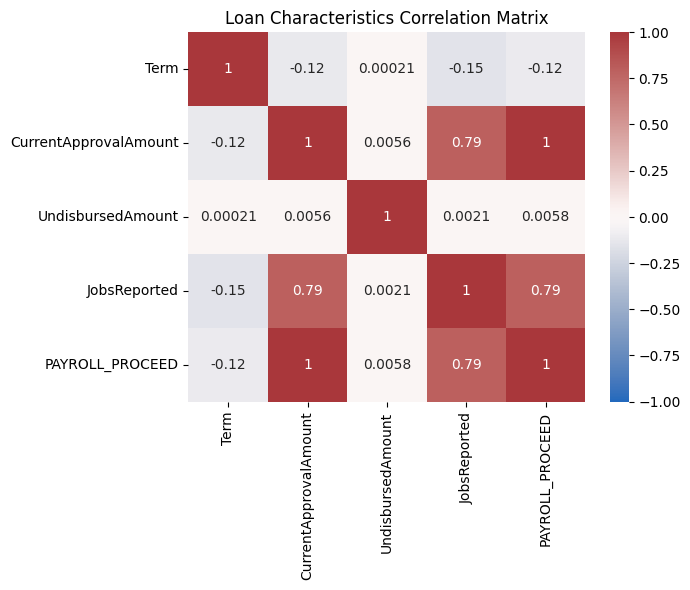

In [ ]:
ax = plt.axes()
sns.heatmap(df_ppp_data_corr, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', xticklabels=1, yticklabels=1, ax = ax)
ax.set_title('Loan Characteristics Correlation Matrix')

plt.show()